In [28]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from src.classes import BallAnomaly, Boundary
from src.util import plot_voxel, plot_voxel_c, voxel_ball
boundary = Boundary()

# Stage 1

Build the variational autoencoder to learn a latent representation of the domain $\Omega \in \mathbb{R}^3$.

Object radius

- 40mm $\rightarrow$ `r= 4`
- 30mm $\rightarrow$ `r= 3`
- 20mm $\rightarrow$ `r= 2`

Material

- acrylic $\rightarrow$ $\gamma$ = 0
- brass $\rightarrow$ $\gamma$ = 1

Literature

- [Variational Autoencoder (VAE) with Discrete Distribution using Gumbel Softmax](https://towardsdatascience.com/variational-autoencoder-vae-with-discrete-distribution-using-gumbel-softmax-b3f749b3417e)

- [Tutorial: Categorical Variational Autoencoders using Gumbel-Softmax](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html)

- [Categorical Reparameterization with Gumbel-Softmax](https://github.com/EderSantana/gumbel)
    - [GitHub Categorical Reparameterization with Gumbel-Softmax](https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb)


- [CAT VAE](https://github.com/flatironinstitute/catvae)

In [39]:
ball = BallAnomaly(x=10, y=10, z=10, r=3, γ=1)

In [40]:
ball_vxl = voxel_ball(ball, boundary)

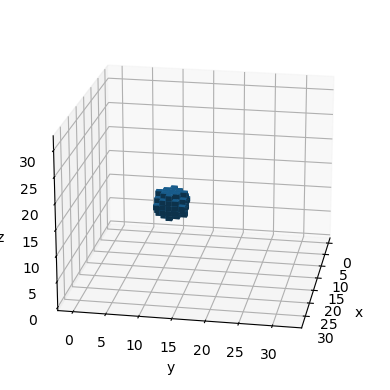

In [41]:
plot_voxel(ball_vxl)

In [42]:
X_all_anomalys = list()
radius_labels = list()

γ = 1 # set object geometries to 1 and empty space to 0
for r in [2, 3, 4]:  # radius
    for x in np.arange(boundary.x_0 + ball.r, boundary.x_length - ball.r, 1):
        for y in np.arange(boundary.y_0 + ball.r, boundary.y_length - ball.r, 1):
            for z in np.arange(boundary.z_0 + ball.r, boundary.z_length - ball.r, 1):
                ball = BallAnomaly(x, y, z, r, γ)
                X_all_anomalys.append(voxel_ball(ball, boundary))
                radius_labels.append(r)

X_all_anomalys = np.array(X_all_anomalys)
radius_labels = np.array(radius_labels)

In [43]:
print(X_all_anomalys.shape, radius_labels.shape)

(54334, 32, 32, 32) (54334,)


In [7]:
X_train, X_test, d_train,d_test = train_test_split(
    X_all_anomalys, radius_labels, train_size=0.9
)

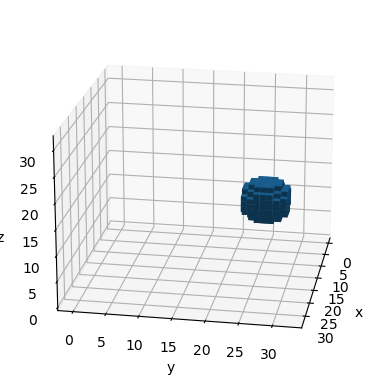

In [8]:
for rdn in np.random.randint(low=0, high=X_train.shape[0], size=5):
    plot_voxel_c(X_train[rdn, ...])

In [9]:
from tensorflow.keras.optimizers import Adam
from src.vae import vae_model

2024-04-10 08:26:34.436479: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 08:26:34.948912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Hyperparametertuning

In [10]:
from src.performance_evaluation import center_of_mass, compute_voxel_err, visualize_errors
import numpy as np
import os

In [11]:
hyperparameters = {
    "beta_s" : np.linspace(0,2, 11),
    "batch_s" : [50,100,150,200,250,300,350,400],
    "epoch_s" : [10,50,100,150,200,250],
    "savepath" : "models/vae_hpt_1/"
}

In [14]:
try:
    os.mkdir(hyperparameters["savepath"])
except BaseException:
    print("[Errno 17] File exists")

[Errno 17] File exists


In [27]:
for epoch in hyperparameters["epoch_s"]:
    for batch in hyperparameters["batch_s"]:
        for beta in hyperparameters["beta_s"]:
            print(f"{epoch=}, {batch=}, {beta=}")
            
            vae = vae_model(input_shape=(32, 32, 32, 1), beta=beta)
            vae.compile(optimizer=Adam())# learning_rate = learning_rate
            
            history = vae.fit(
                np.expand_dims(X_train, 4),
                epochs=epoch,
                batch_size=batch,
            )
            # postprocessing and savings
            path = f"{hyperparameters['savepath']}ep_{epoch}_ba_{batch}_be_{int(10*np.round(beta,1))}"
            vae.save_weights(f"{path}.weights.h5")
            
            _, _, z = vae.encoder.predict(X_test)
            pred = vae.decoder.predict(z)
            pred = np.squeeze(pred, axis=4)
            pred = np.clip(pred, a_min=0, a_max=1)

            np.savez(f"{path}_saves.npz",
                     history=history.history,
                     hyperparameters=hyperparameters,
                     test = X_test,
                     pred = pred,
                    )

epoch=10, batch=50, beta=0.0
Epoch 1/10
747/747 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - kl_loss: 48.0366 - loss: 1535.4128 - reconstruction_loss: 1535.3452 - total_loss: 1535.3452
Epoch 2/10
747/747 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - kl_loss: 72.7282 - loss: 1443.8074 - reconstruction_loss: 1443.7974 - total_loss: 1443.7974
Epoch 3/10
747/747 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - kl_loss: 81.6113 - loss: 1412.4216 - reconstruction_loss: 1412.4224 - total_loss: 1412.4224
Epoch 4/10
747/747 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - kl_loss: 97.7094 - loss: 1405.1304 - reconstruction_loss: 1405.1379 - total_loss: 1405.1379
Epoch 5/10
747/747 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - kl_loss: 99.3768 - loss: 1423.0049 - reconstruction_loss: 1422.9880 - total_loss: 1422.9879
Epoch 6/10
747/747 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - kl_loss: 100.2786 - loss: 1408.3666 - reconstruction_loss: 1408.3707 - total_loss: 1408.3707
Epoch 7/10
747/747 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - kl_loss: 99.9993 - loss: 1

KeyboardInterrupt: 

## Further evaluation